In [13]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [14]:
warnings.filterwarnings("ignore")

In [15]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [16]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [17]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [18]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [19]:
df = read_csv_replace_missing_by_polynomial('idh_longevidade.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1991,0.623,0.543,0.627,0.613,0.601,0.595,0.674,0.647,0.636,0.596,...,0.663,0.642,0.593,0.62,0.613,0.685,0.691,0.58,0.673,0.631
2012,0.791,0.749,0.764,0.796,0.79,0.796,0.865,0.863,0.807,0.739,...,0.846,0.832,0.827,0.758,0.752,0.86,0.878,0.775,0.863,0.785
2013,0.797,0.756,0.769,0.801,0.794,0.801,0.87,0.87,0.81,0.744,...,0.852,0.837,0.831,0.762,0.757,0.865,0.885,0.779,0.869,0.79
2014,0.804,0.763,0.773,0.806,0.799,0.804,0.875,0.876,0.813,0.749,...,0.857,0.843,0.836,0.765,0.763,0.87,0.89,0.784,0.875,0.795
2015,0.809,0.769,0.777,0.811,0.803,0.808,0.879,0.882,0.815,0.754,...,0.862,0.848,0.84,0.769,0.768,0.875,0.896,0.788,0.88,0.8
2016,0.815,0.776,0.781,0.815,0.807,0.812,0.884,0.887,0.818,0.759,...,0.867,0.853,0.844,0.772,0.774,0.88,0.902,0.793,0.885,0.805
2017,0.82,0.782,0.785,0.82,0.811,0.816,0.888,0.892,0.821,0.764,...,0.872,0.858,0.848,0.775,0.779,0.884,0.907,0.797,0.889,0.809
2018,0.825,0.788,0.789,0.824,0.815,0.819,0.892,0.897,0.824,0.769,...,0.877,0.863,0.851,0.778,0.784,0.888,0.912,0.801,0.894,0.814
2019,0.83,0.793,0.792,0.828,0.818,0.823,0.896,0.902,0.827,0.773,...,0.882,0.867,0.855,0.781,0.788,0.893,0.916,0.805,0.898,0.818


In [20]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013)) + list(range(2022,2023))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

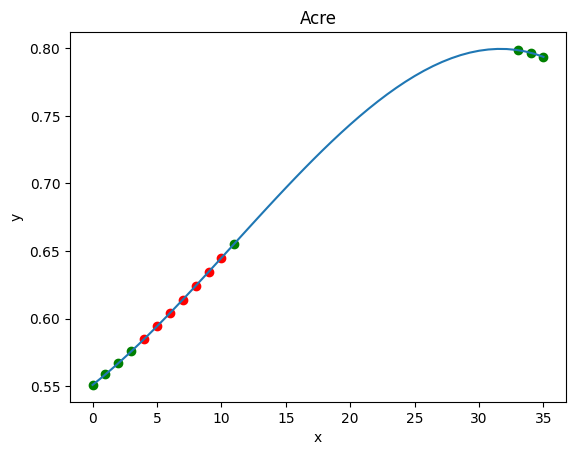

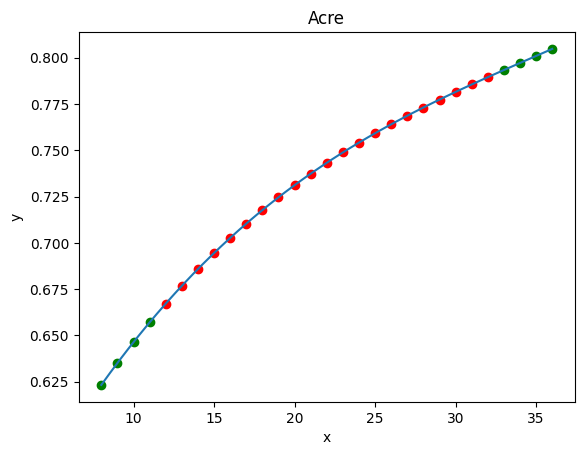

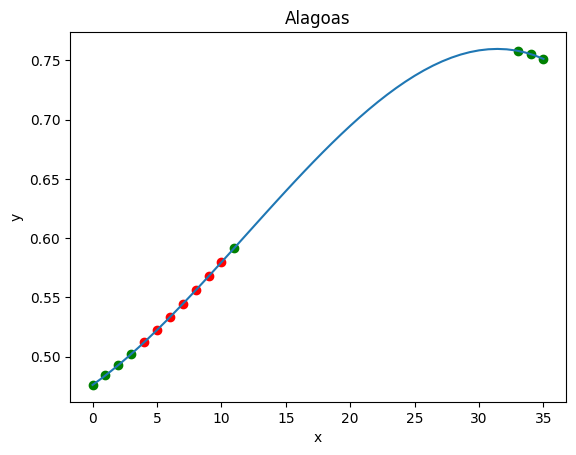

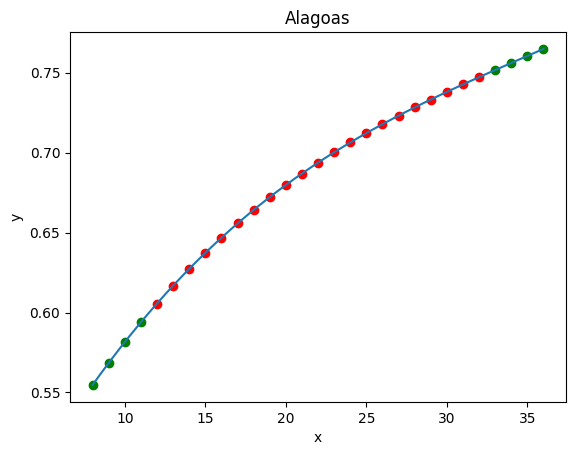

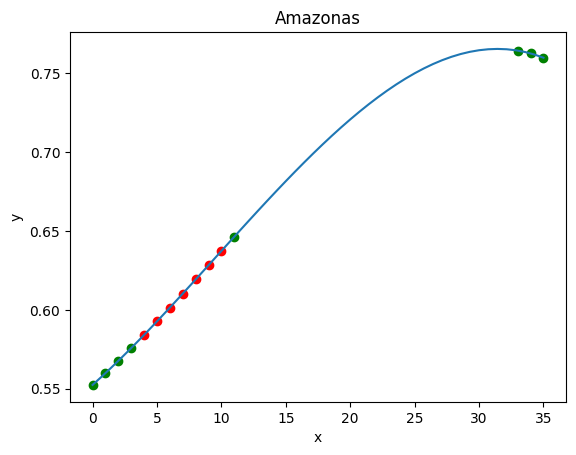

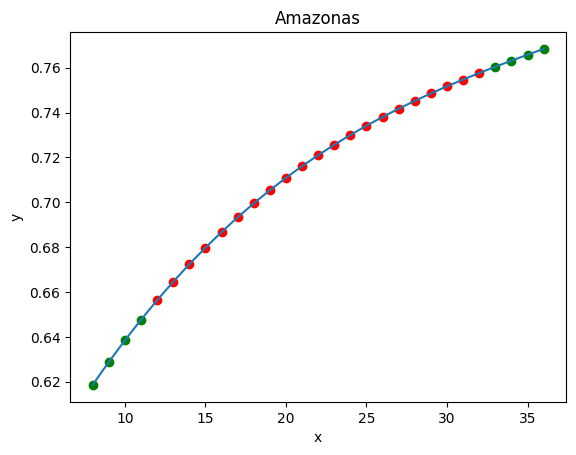

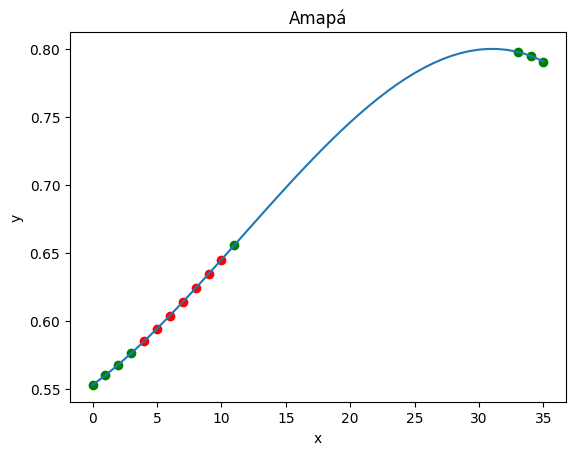

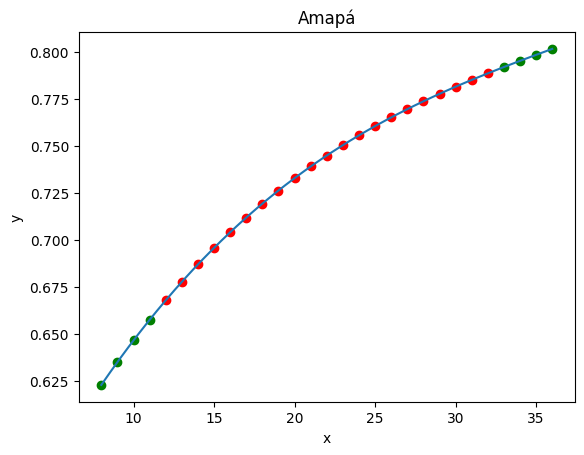

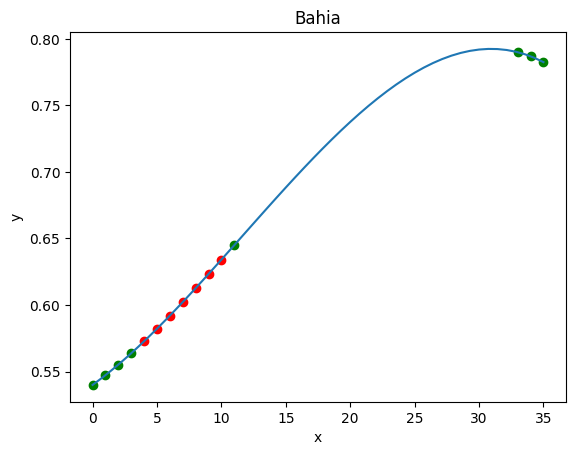

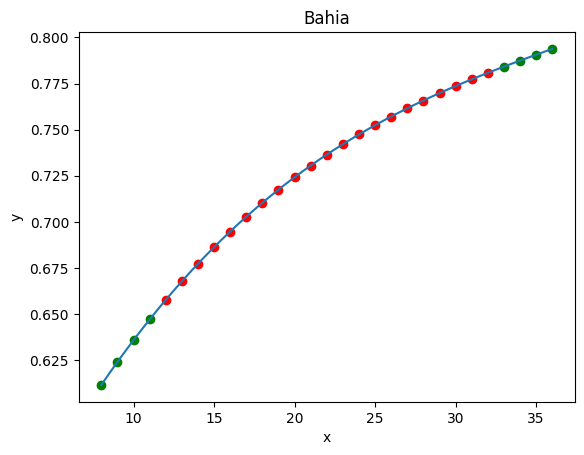

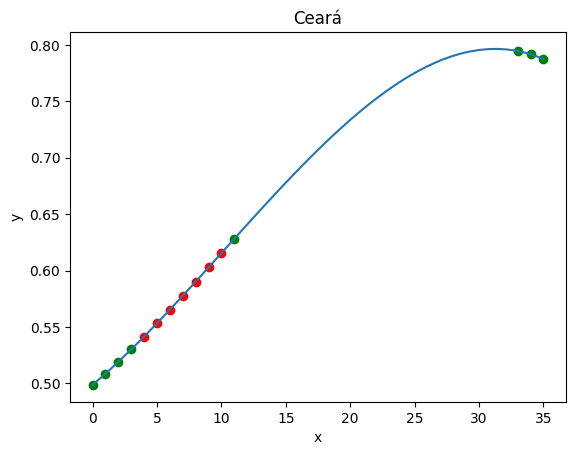

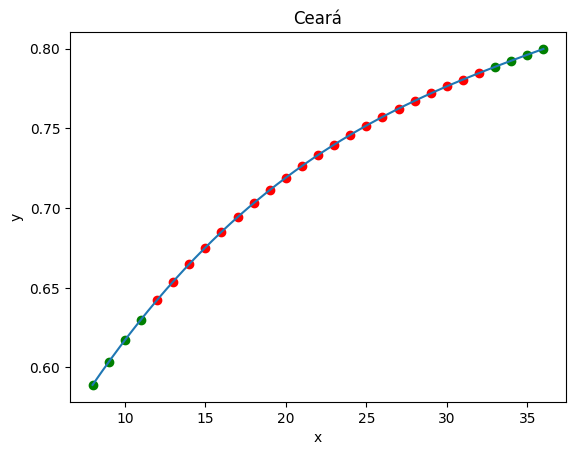

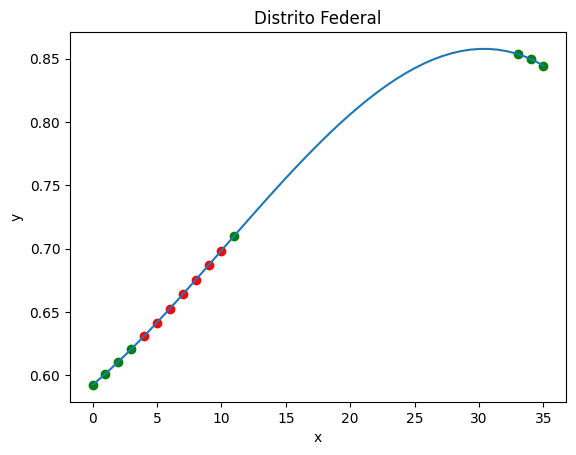

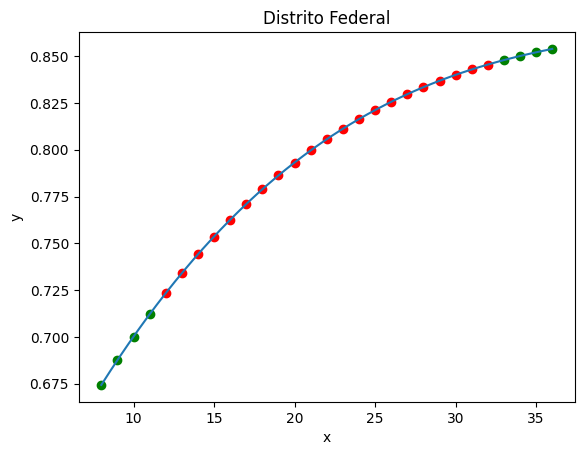

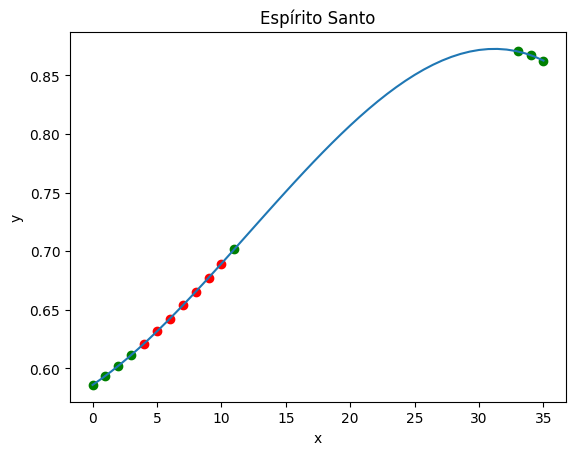

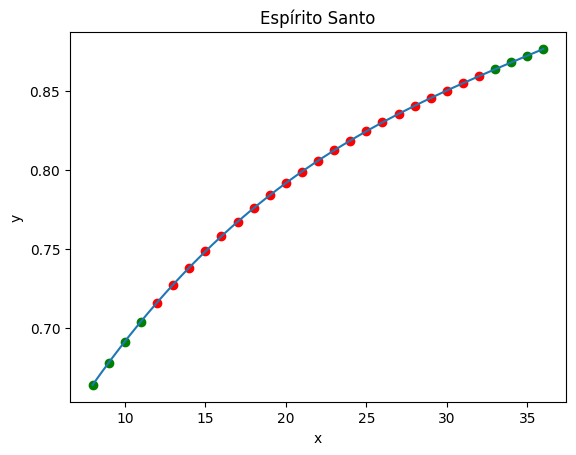

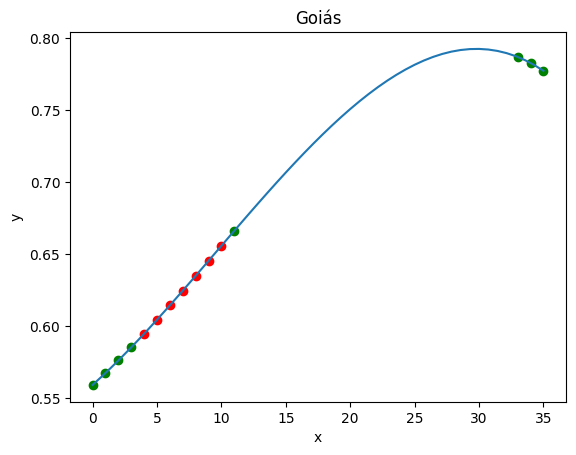

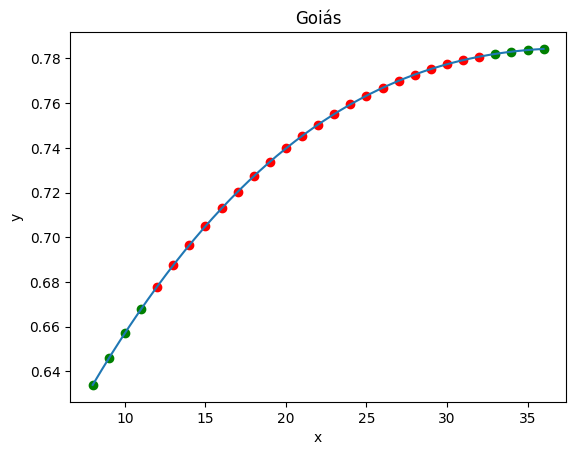

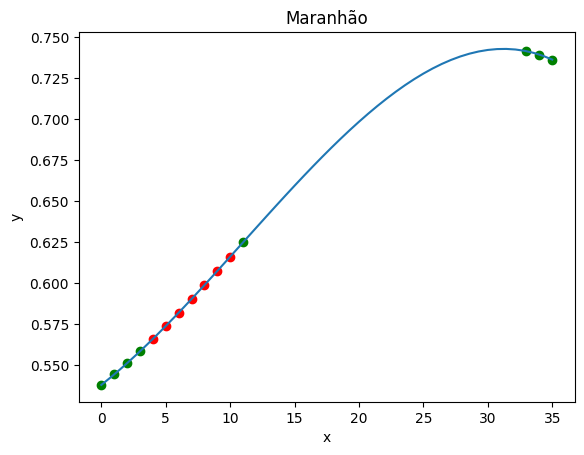

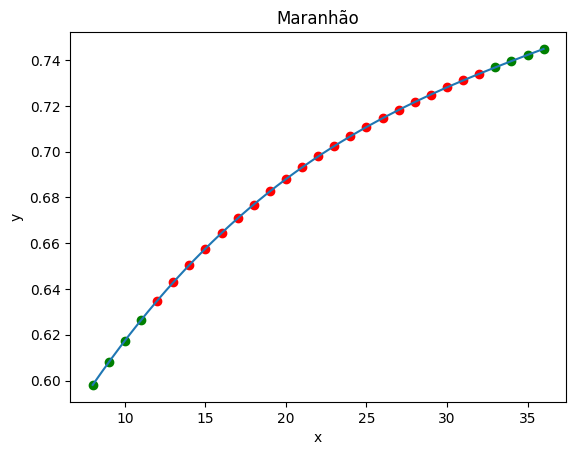

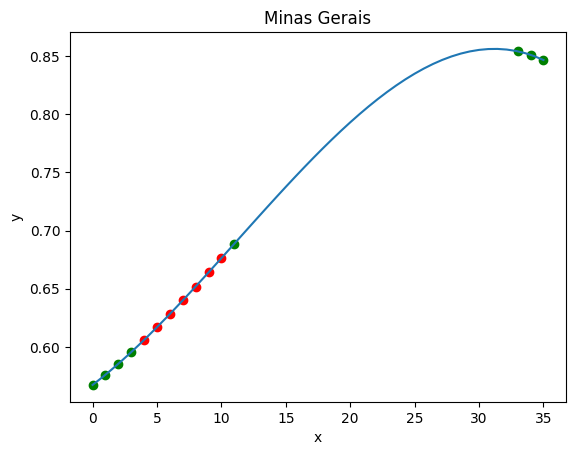

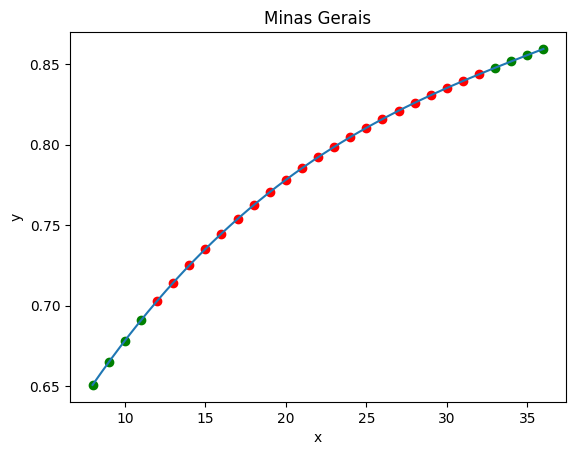

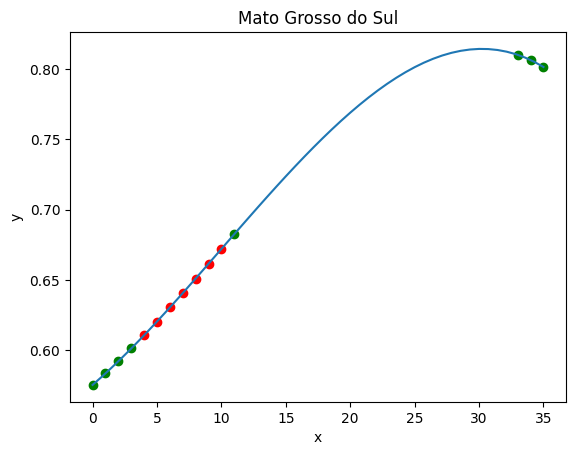

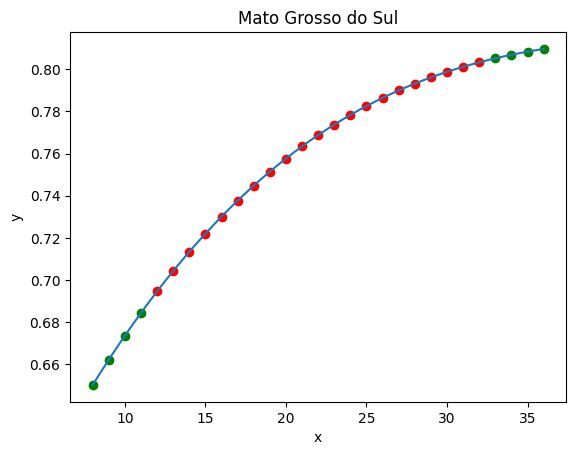

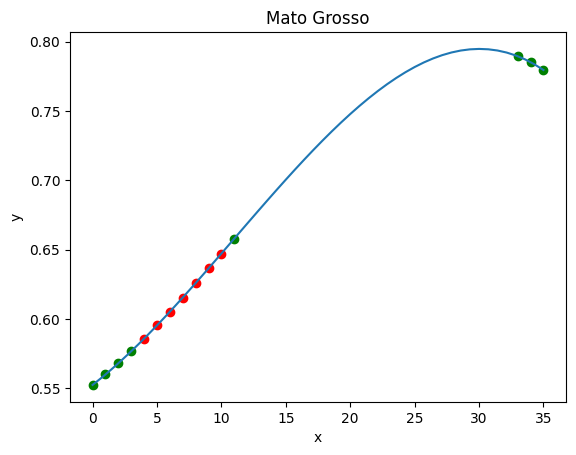

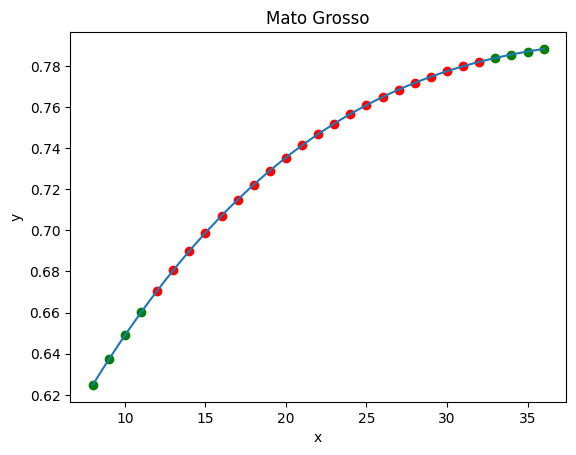

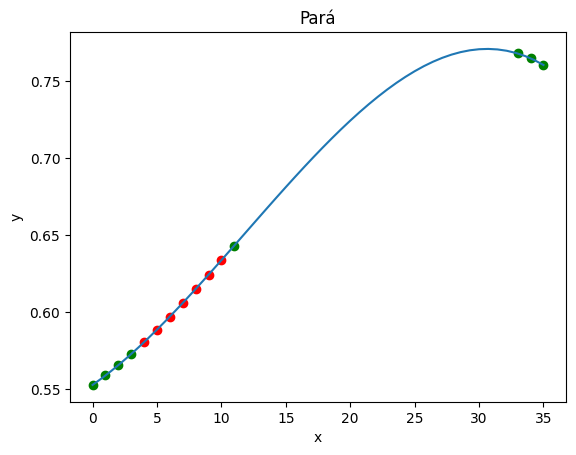

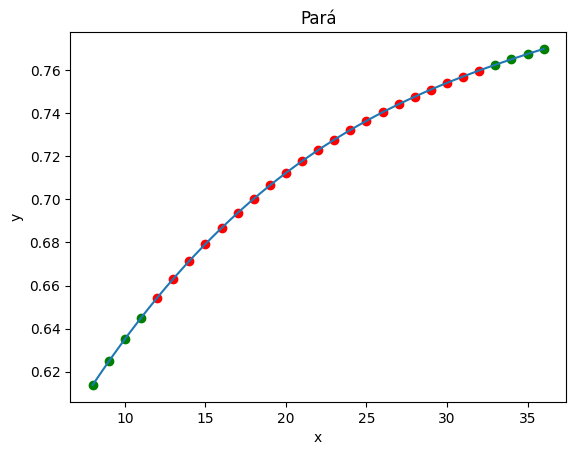

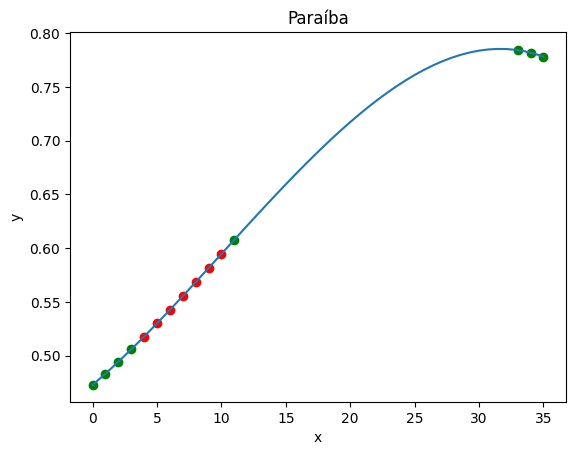

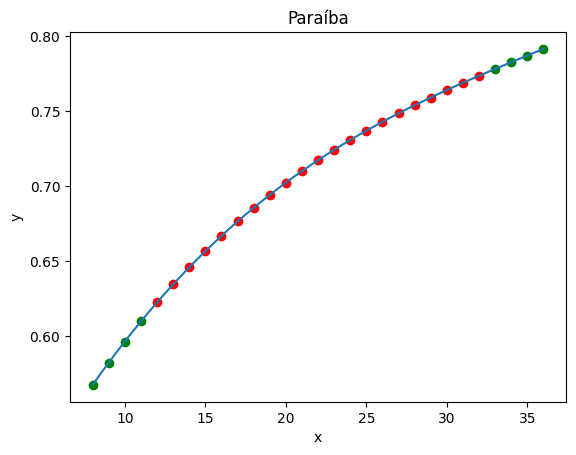

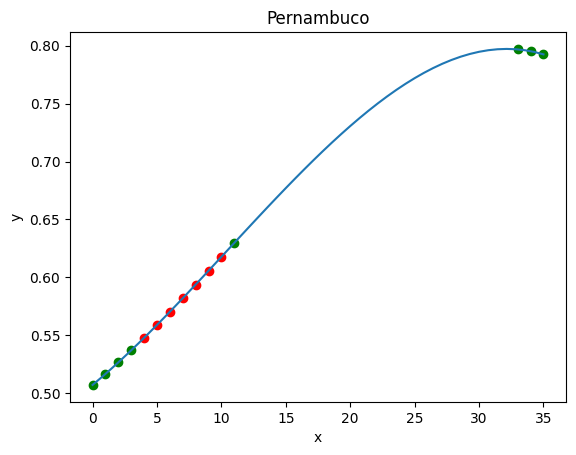

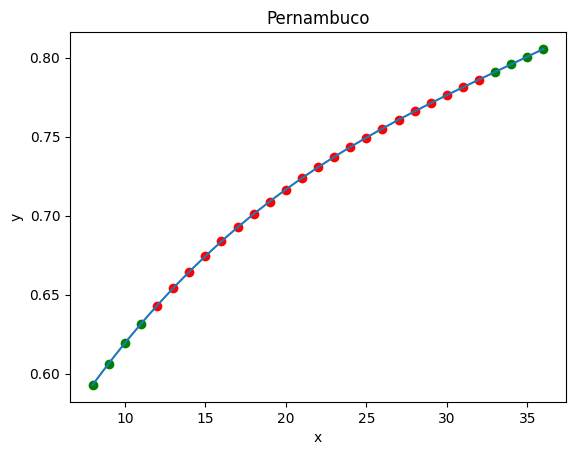

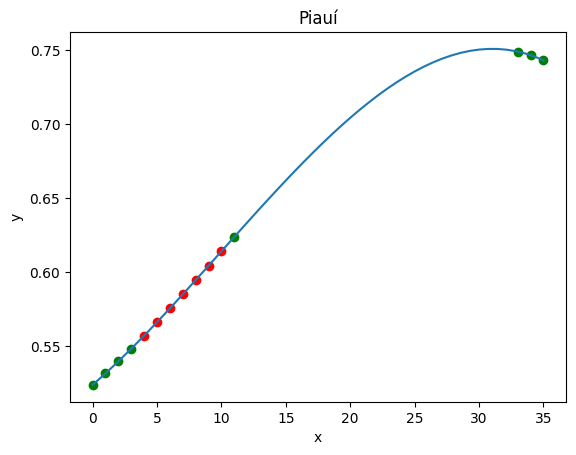

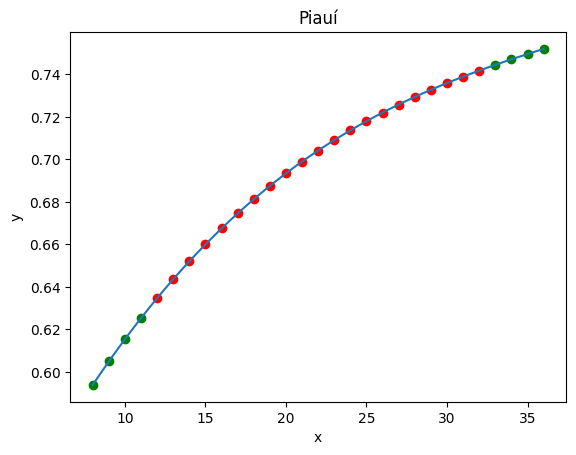

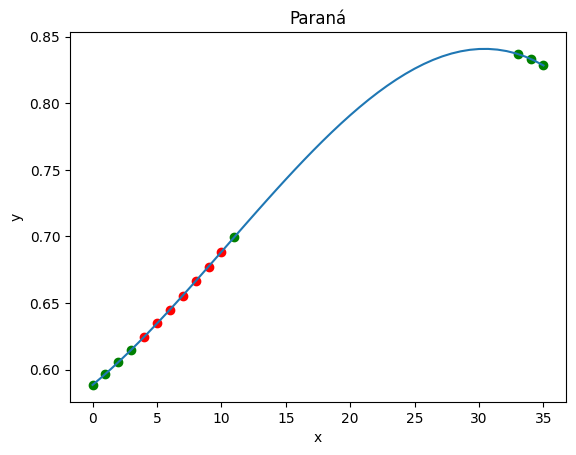

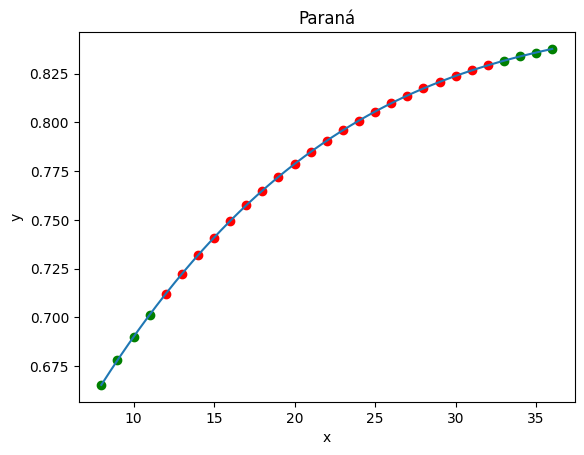

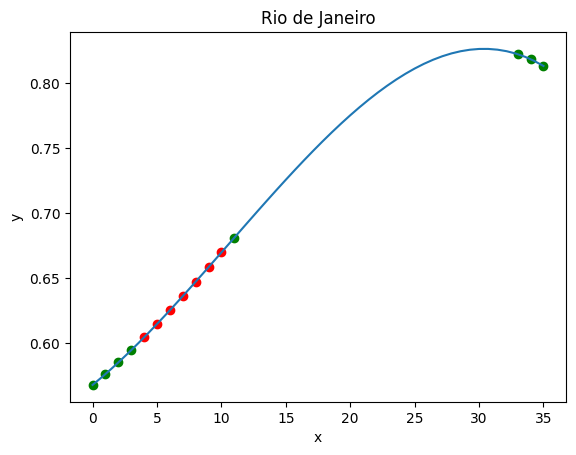

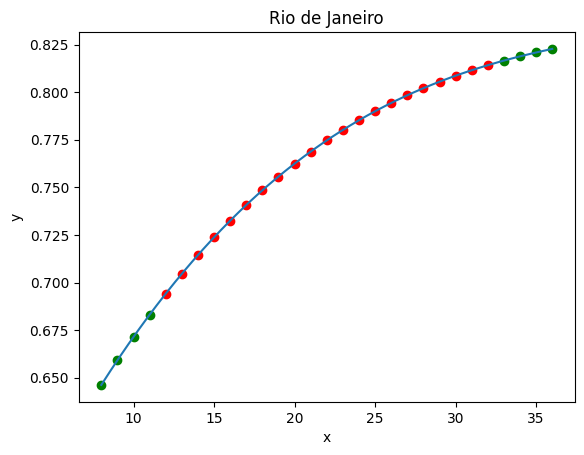

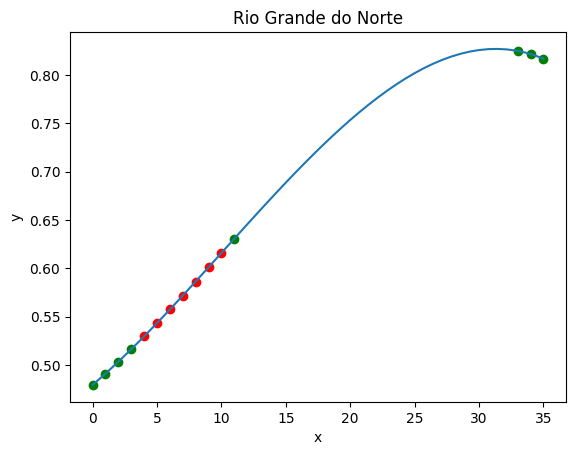

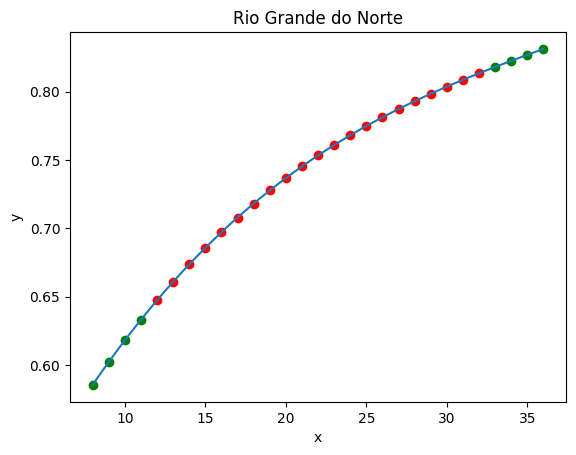

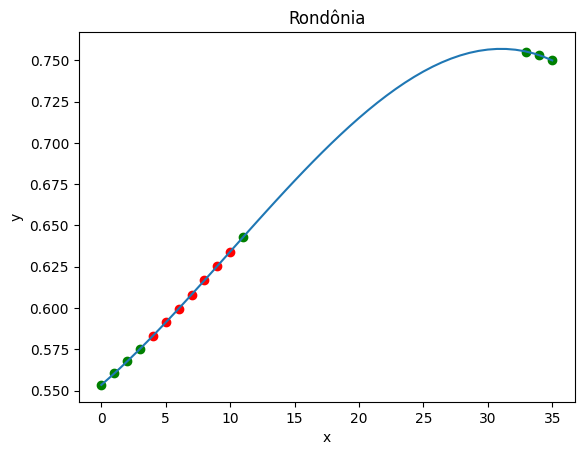

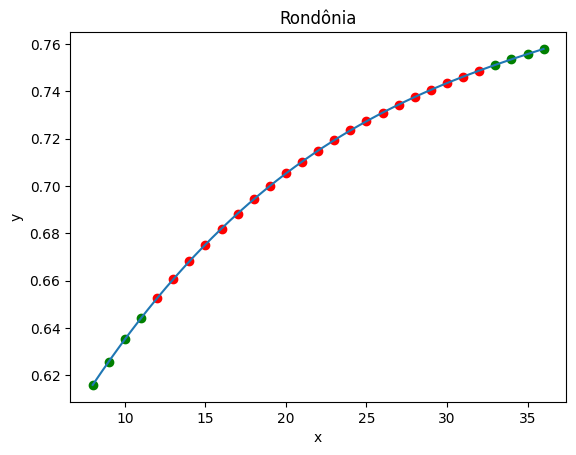

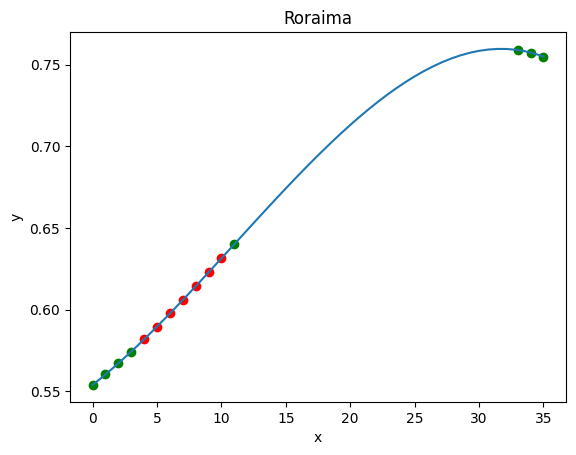

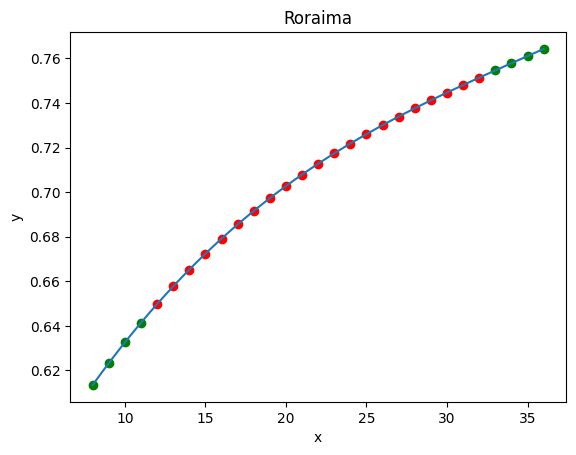

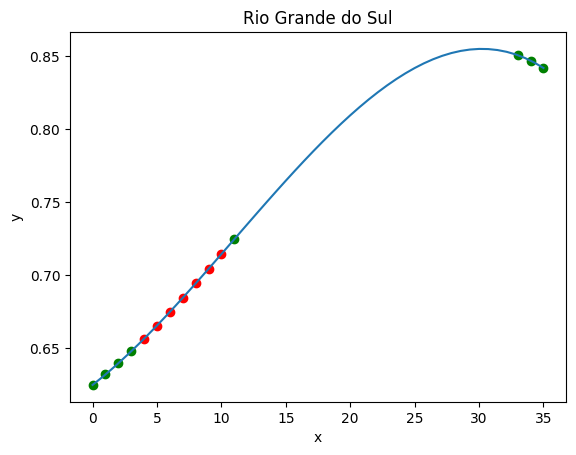

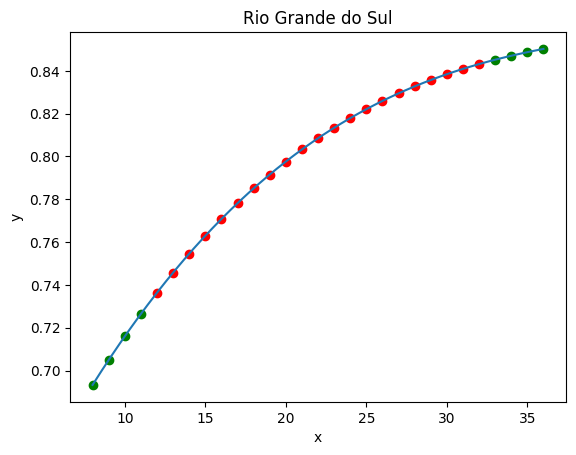

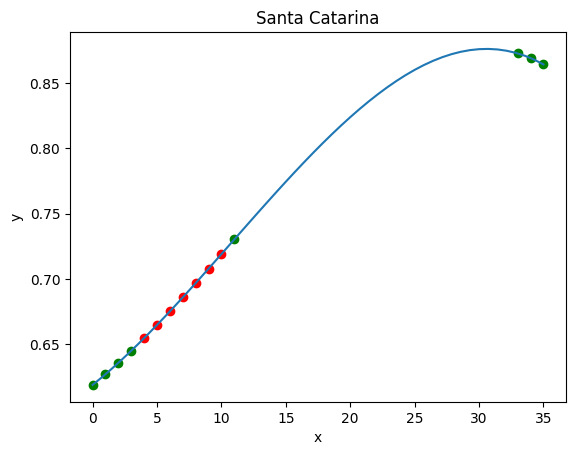

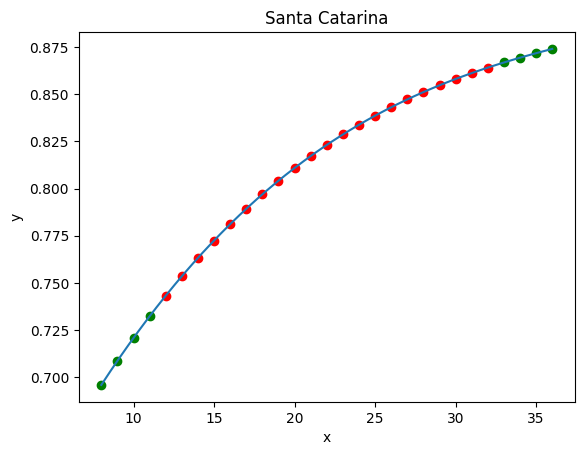

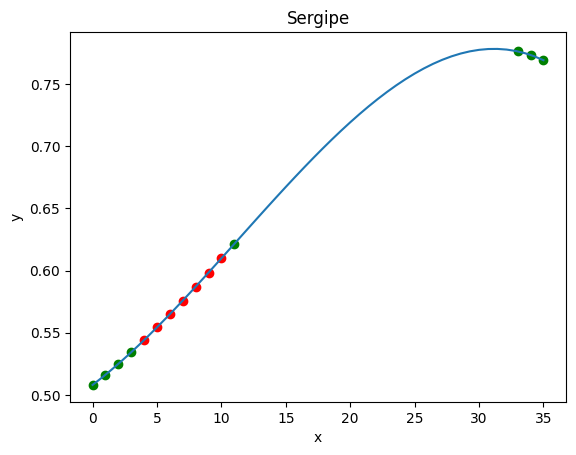

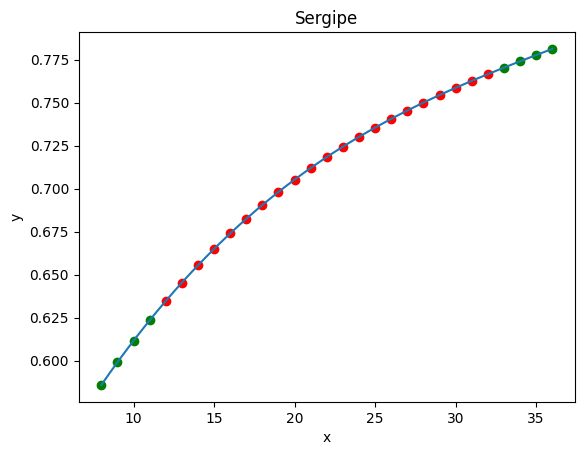

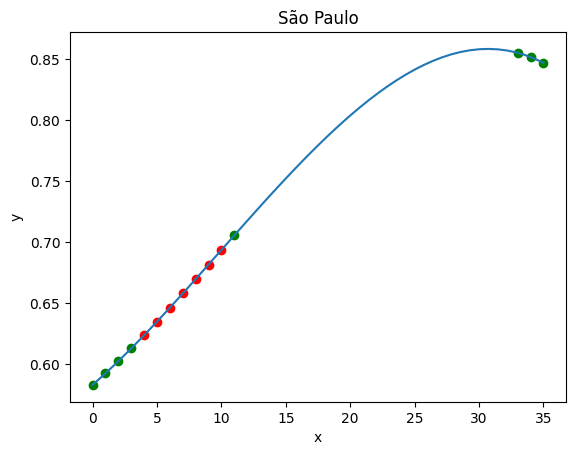

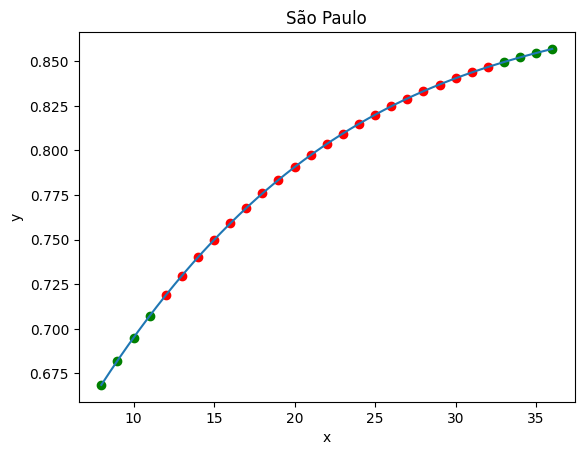

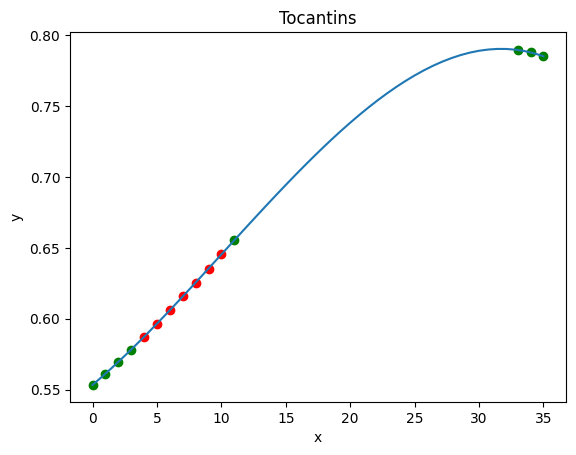

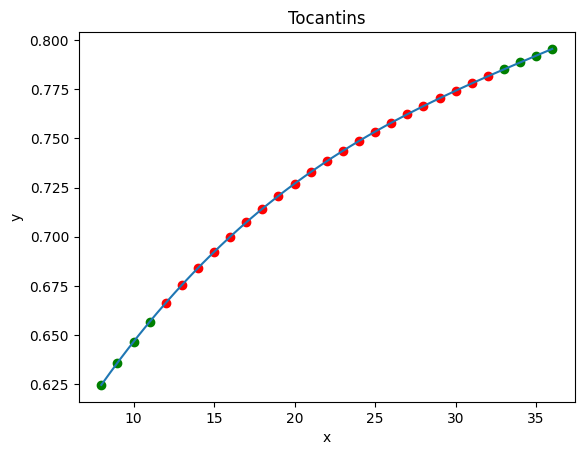

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.553909,0.480127,0.554455,0.556345,0.543655,0.501727,0.595927,0.590345,0.562073,0.540727,...,0.591836,0.571527,0.483145,0.555745,0.556345,0.628345,0.622600,0.511600,0.585945,0.555691
1981,0.560091,0.485753,0.560945,0.561415,0.548785,0.510073,0.602913,0.595415,0.568687,0.545673,...,0.598204,0.577833,0.492975,0.561495,0.561415,0.633415,0.628720,0.517720,0.593735,0.562429
1982,0.565691,0.490849,0.566825,0.566007,0.553433,0.517633,0.609241,0.600007,0.574679,0.550153,...,0.603972,0.583545,0.501879,0.566703,0.566007,0.638007,0.634264,0.523264,0.600791,0.568533
1983,0.570593,0.495309,0.571972,0.570026,0.557502,0.524250,0.614780,0.604026,0.579924,0.554074,...,0.609021,0.588545,0.509672,0.571261,0.570026,0.642026,0.639117,0.528117,0.606967,0.573876
1984,0.584856,0.512016,0.584144,0.584866,0.572735,0.541457,0.631043,0.621203,0.594608,0.566117,...,0.624538,0.604511,0.529699,0.583182,0.581811,0.656478,0.654830,0.544095,0.623498,0.587280
1985,0.594301,0.522407,0.592704,0.594111,0.582194,0.553226,0.641723,0.631585,0.604353,0.573965,...,0.634604,0.614762,0.543445,0.591304,0.589601,0.665485,0.664897,0.554337,0.634651,0.596551
1986,0.604038,0.533232,0.601438,0.603728,0.592040,0.565296,0.652706,0.642451,0.614341,0.582066,...,0.644976,0.625341,0.557533,0.599628,0.597634,0.674822,0.675298,0.564949,0.646078,0.606045
1987,0.614018,0.544426,0.610308,0.613661,0.602212,0.577608,0.663933,0.653733,0.624519,0.590379,...,0.655598,0.636189,0.571897,0.608113,0.605871,0.684432,0.685975,0.575870,0.657723,0.615720
1988,0.624191,0.555927,0.619277,0.623852,0.612653,0.590105,0.675348,0.665363,0.634835,0.598861,...,0.666414,0.647247,0.586471,0.616720,0.614271,0.694262,0.696870,0.587043,0.669531,0.625533


In [24]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [26]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.796188,0.754811,0.761764,0.793503,0.785796,0.790518,0.847405,0.866497,0.779847,0.738420,...,0.831380,0.816271,0.820342,0.751899,0.757094,0.844691,0.867205,0.772499,0.849730,0.787389
2015,0.808026,0.768560,0.771049,0.804619,0.797084,0.803775,0.857083,0.880249,0.786917,0.747557,...,0.840756,0.825826,0.835829,0.760424,0.766989,0.853023,0.877280,0.784877,0.860278,0.798488
2016,0.807937,0.768520,0.770508,0.804039,0.796546,0.803391,0.855090,0.880090,0.784364,0.746972,...,0.838825,0.823810,0.835449,0.759644,0.766897,0.851025,0.875578,0.784594,0.858485,0.798351
2017,0.807295,0.767840,0.769554,0.803042,0.795596,0.802608,0.852462,0.879462,0.781307,0.745878,...,0.836263,0.821157,0.834672,0.758521,0.766251,0.848391,0.873176,0.783829,0.856075,0.797746
2018,0.806140,0.766553,0.768150,0.801501,0.794196,0.801391,0.849232,0.878322,0.777698,0.744231,...,0.833015,0.817807,0.833461,0.757023,0.765092,0.845154,0.870101,0.782632,0.853082,0.796723
2019,0.804426,0.764603,0.766254,0.799455,0.792304,0.799790,0.845344,0.876624,0.773489,0.741979,...,0.829016,0.813699,0.831866,0.755116,0.763373,0.841259,0.866292,0.780962,0.849362,0.795153
2020,0.802101,0.762022,0.763914,0.796860,0.789968,0.797680,0.840738,0.874317,0.768624,0.739159,...,0.824199,0.808854,0.829763,0.752762,0.761135,0.836555,0.861773,0.778777,0.844940,0.793076
2021,0.800019,0.759842,0.762178,0.795211,0.788056,0.795469,0.841169,0.872437,0.769135,0.737446,...,0.824581,0.809295,0.827469,0.751195,0.759147,0.837060,0.862116,0.776575,0.845026,0.790901
2022,0.801112,0.760918,0.763831,0.796776,0.789516,0.796512,0.844639,0.873204,0.773511,0.739486,...,0.828179,0.812958,0.828239,0.753031,0.760433,0.840702,0.865309,0.777718,0.848210,0.791983


In [27]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_long_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)